In [1]:
%config Completer.use_jedi = False
# fixes firefox tab completion

In [2]:
# Importing the required libraries
import numpy as np
import pandas as pd
from math import log2, sqrt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.fft import fft, ifft
from scipy.special import erfc
import itertools

In [3]:
pd.options.mode.copy_on_write = "warn"

In [4]:
# todo: some of these take a longggg time 

In [5]:
# Concatenate data
def concatenateData(df, num_concats):
    if num_concats == 0: # do nothing
        return df.rename(columns={'binary_number': 'bitstring'})
    new_df = pd.DataFrame({
        'bitstring': [''] * (len(df) // num_concats), 
        'label': [0] * (len(df) // num_concats)
    })

    # Loop through each group of num_concats rows and concatenate their 'binary_number' strings
    for i in range(0, len(df), num_concats):
        new_df.iloc[i // num_concats, 0] = ''.join(df['binary_number'][i:i + num_concats])
        new_df.iloc[i // num_concats, 1] = df['label'][i]

    return new_df

# Calculate Shannon entropy for each concatenated binary sequence
def shannon_entropy(binary_string):
    if len(binary_string) % 2 != 0:
        raise ValueError("Binary string length must be a multiple of 2.")
    
    patterns = ['00', '10', '11', '01']
    frequency = {pattern: 0 for pattern in patterns}
    
    for i in range(0, len(binary_string), 2):
        segment = binary_string[i:i+2]
        if segment in patterns:
            frequency[segment] += 1
    
    total_segments = sum(frequency.values())
    
    entropy = 0
    for count in frequency.values():
        if count > 0:
            probability = count / total_segments
            entropy -= probability * log2(probability)
    
    return entropy


def classic_spectral_test(bit_string):
    bit_array = 2 * np.array([int(bit) for bit in bit_string]) - 1
    dft = fft(bit_array)
    n_half = len(bit_string) // 2 + 1
    mod_dft = np.abs(dft[:n_half])
    threshold = np.sqrt(np.log(1 / 0.05) / len(bit_string))
    peaks_below_threshold = np.sum(mod_dft < threshold)
    expected_peaks = 0.95 * n_half
    d = (peaks_below_threshold - expected_peaks) / np.sqrt(len(bit_string) * 0.95 * 0.05)
    p_value = erfc(np.abs(d) / np.sqrt(2)) / 2
    return d

def frequency_test(bit_string):
    n = len(bit_string)
    count_ones = bit_string.count('1')
    count_zeros = bit_string.count('0')
    
    # The test statistic
    s = (count_ones - count_zeros) / sqrt(n)
    
    # The p-value
    p_value = erfc(abs(s) / sqrt(2))
    
    return p_value

def runs_test(bit_string):
    n = len(bit_string)
    runs = 1  # Start with the first run
    for i in range(1, n):
        if bit_string[i] != bit_string[i - 1]:
            runs += 1
    
    n0 = bit_string.count('0')
    n1 = bit_string.count('1')
    
    # Expected number of runs
    expected_runs = (2 * n0 * n1 / n) + 1
    variance_runs = (2 * n0 * n1 * (2 * n0 * n1 - n)) / (n ** 2 * (n - 1))
    
    # The test statistic
    z = (runs - expected_runs) / sqrt(variance_runs)
    
    # The p-value
    p_value = erfc(abs(z) / sqrt(2))
    
    return p_value

def linear_complexity(bit_string, M=500):
    # Perform linear complexity test with block size M
    n = len(bit_string)
    bit_array = np.array([int(bit) for bit in bit_string])
    lc = 0  # Initialize linear complexity
    
    # Process blocks of size M
    for i in range(0, n, M):
        block = bit_array[i:i+M]
        if len(block) < M:
            continue
        
        lc_block = 0
        for j in range(M):
            if block[j] == 1:
                lc_block = j + 1
        
        lc += lc_block
    
    lc = lc / (n / M)
    return lc

def autocorrelation_test(bit_string, lag=1):
    n = len(bit_string)
    bit_array = np.array([int(bit) for bit in bit_string])
    autocorrelation = np.correlate(bit_array, np.roll(bit_array, lag), mode='valid')[0]
    return autocorrelation / n

def maurer_universal_test(bit_string):
    k = 6
    l = 5
    q = 20
    bit_array = np.array([int(bit) for bit in bit_string])
    max_val = 2**k
    init_subseq = bit_array[:q]
    rest_subseq = bit_array[q:]
    d = {}
    for i in range(len(init_subseq) - k + 1):
        d[tuple(init_subseq[i:i+k])] = i
    t = []
    for i in range(len(rest_subseq) - k + 1):
        subseq = tuple(rest_subseq[i:i+k])
        if subseq in d:
            t.append(i - d[subseq])
            d[subseq] = i
    if not t:
        return 0
    t = np.array(t)
    log_avg = np.mean(np.log2(t))
    return log_avg - np.log2(q)

def binary_matrix_rank_test(bit_string, M=32, Q=32):
    bit_array = np.array([int(bit) for bit in bit_string])
    num_matrices = len(bit_array) // (M * Q)
    ranks = []
    for i in range(num_matrices):
        matrix = bit_array[i*M*Q:(i+1)*M*Q].reshape((M, Q))
        rank = np.linalg.matrix_rank(matrix)
        ranks.append(rank)
    return np.mean(ranks)

def cumulative_sums_test(bit_string):
    bit_array = np.array([int(bit) for bit in bit_string])
    adjusted = 2 * bit_array - 1
    cumulative_sum = np.cumsum(adjusted)
    max_excursion = np.max(np.abs(cumulative_sum))
    return max_excursion

def longest_run_ones_test(bit_string, block_size=100):
    bit_array = np.array([int(bit) for bit in bit_string])
    num_blocks = len(bit_array) // block_size
    max_runs = []
    for i in range(num_blocks):
        block = bit_array[i*block_size:(i+1)*block_size]
        max_run = max([len(list(g)) for k, g in itertools.groupby(block) if k == 1])
        max_runs.append(max_run)
    return np.mean(max_runs)

def random_excursions_test(bit_string):
    bit_array = np.array([int(bit) for bit in bit_string])
    bit_array = 2 * bit_array - 1  # Convert to ±1

    cumulative_sum = np.cumsum(bit_array)
    states = np.unique(cumulative_sum)

    if 0 not in states:
        states = np.append(states, 0)
    state_counts = {state: 0 for state in states}
    for state in cumulative_sum:
        state_counts[state] += 1

    state_counts[0] -= 1  # Adjust for zero state
    pi = [0.5 * (1 - (1 / (2 * state + 1)**2)) for state in states]
    x = np.sum([(state_counts[state] - len(bit_string) * pi[i])**2 / (len(bit_string) * pi[i]) for i, state in enumerate(states)])

    return x


def unique_subsequences(bit_string, length=4):
    bit_array = np.array([int(bit) for bit in bit_string])
    n = len(bit_array)
    subsequences = set()
    
    for i in range(n - length + 1):
        subseq = tuple(bit_array[i:i+length])
        subsequences.add(subseq)
    
    return len(subsequences)

def sample_entropy(bit_string, m=2, r=0.2):
    bit_array = np.array([int(bit) for bit in bit_string])
    N = len(bit_array)
    
    def _phi(m):
        x = np.array([bit_array[i:i+m] for i in range(N - m + 1)])
        C = np.sum(np.all(np.abs(x[:, None] - x) <= r, axis=2), axis=0) / (N - m + 1.0)
        return np.sum(C) / (N - m + 1.0)
    
    return -np.log(_phi(m + 1) / _phi(m))

def permutation_entropy(bit_string, order=3):
    bit_array = np.array([int(bit) for bit in bit_string])
    n = len(bit_array)
    
    permutations = np.array(list(itertools.permutations(range(order))))
    c = np.zeros(len(permutations))
    
    for i in range(n - order + 1):
        sorted_index_array = tuple(np.argsort(bit_array[i:i+order]))
        for j, p in enumerate(permutations):
            if np.array_equal(p, sorted_index_array):
                c[j] += 1
    
    c = c / (n - order + 1)
    pe = -np.sum(c * np.log2(c + np.finfo(float).eps))
    return pe

def lyapunov_exponent(bit_string, m=2, t=1):
    bit_array = np.array([int(bit) for bit in bit_string])
    N = len(bit_array)
    
    def _phi(m):
        x = np.array([bit_array[i:i+m] for i in range(N - m + 1)])
        C = np.sum(np.all(np.abs(x[:, None] - x) <= t, axis=2), axis=0) / (N - m + 1.0)
        return np.sum(np.log(C + np.finfo(float).eps)) / (N - m + 1.0)
    
    return abs(_phi(m) - _phi(m + 1))

def entropy_rate(bit_string, k=2):
    bit_array = np.array([int(bit) for bit in bit_string])
    n = len(bit_array)
    prob = {}
    
    for i in range(n - k + 1):
        subseq = tuple(bit_array[i:i + k])
        if subseq in prob:
            prob[subseq] += 1
        else:
            prob[subseq] = 1
    
    for key in prob:
        prob[key] /= (n - k + 1)
    
    entropy_rate = -sum(p * log2(p) for p in prob.values())
    return entropy_rate


# Calculate min-entropy
def calculate_min_entropy(sequence):
    sequence = np.asarray(sequence, dtype=float)  # Convert sequence to float
    p = np.mean(sequence)  # Proportion of ones
    max_prob = max(p, 1 - p)
    if max_prob == 0:  # Handle the case where all bits are the same
        return 0
    min_entropy = -np.log2(max_prob)
    return min_entropy


# Apply randomness tests
def apply_randomness_tests(df, tests):
    if not tests:
        raise ValueError("No randomness tests specified.")

    test_functions = {
        'autocorrelation': autocorrelation_test,
        'cumulative_sums': cumulative_sums_test,
        'spectral_test': classic_spectral_test,
        'frequency_test': frequency_test,
        'runs_test': runs_test,
        'shannon_entropy': shannon_entropy,
        'min_entropy': calculate_min_entropy,
        'entropy_rate': entropy_rate,
        'lyapunov_exponent': lyapunov_exponent,
        'permutation_entropy': permutation_entropy,
        'sample_entropy': sample_entropy,
        'unique_subsequences': unique_subsequences,
        'random_excursions_test': random_excursions_test,
        'longest_run_ones_test': longest_run_ones_test,
        'cumulative_sums_test': cumulative_sums_test,
        'binary_matrix_rank_test': binary_matrix_rank_test,
        'maurer_universal_test': maurer_universal_test,
        'linear_complexity': linear_complexity,
    }

    for i, test in enumerate(tests):
        if test not in test_functions:
            raise ValueError(f"Invalid randomness test: {test}")
        print(f'Running test {i+1}/{len(tests)}: {test}')
        df[test] = df['bitstring'].apply(test_functions[test])

    return df

# Preprocess data
def preprocess_data(df, num_concats, tests):
    df = concatenateData(df, num_concats)
    processed_df = apply_randomness_tests(df, tests)
    
    # Convert concatenated binary strings into separate columns
    df_features = pd.DataFrame(processed_df['bitstring'].apply(list).tolist()).astype(int).astype(bool)
    processed_df = pd.concat([processed_df.drop(columns='bitstring'), df_features], axis=1)

    return processed_df



# Main
file_path = 'AI_2qubits_training_data.txt'

# Read the data from the file
data = []
with open(file_path, 'r') as file:
    for line in file:
        if line.strip():
            binary_number, label = line.strip().split()
            data.append((binary_number, int(label)))

# Convert the data into a DataFrame
df = pd.DataFrame(data, columns=['binary_number', 'label'])


In [6]:
data_df = pd.read_csv('AI_2qubits_training_data.txt', delimiter=' ', names=['bitstring', 'label'])

In [7]:
data_df

,bitstring,label
0,0100111111110000000000101110100011011011110000...,1
1,0110011011110001111110001000001110011110011100...,1
2,1110100101110111111101101100110101111101010001...,1
3,1101000011100100011101001110111100011110100111...,1
4,0000000000100101001101100000101000101110110001...,1
...,...,...
13995,1111010111001101111011010000011011100100111100...,4
13996,0101100011000001111011001010001101110100000101...,4
13997,1100111100111101111000001100010010001111111011...,4
13998,1101110000111110011101001100111100001011000010...,4


In [8]:
def binary_series_to_string(x):
    return ''.join(x['bitstring'].to_list())

# work around deprecation warning
single_string_df = data_df.groupby('label')[['label','bitstring']].apply(binary_series_to_string)
single_string_df = pd.DataFrame(single_string_df, columns=['bitstring'])
single_string_df

,bitstring
label,
1,0100111111110000000000101110100011011011110000...
2,0110011100111011110010111100100101000101101111...
3,1001000011110111101011010100111001000001001100...
4,0011011101000100100001010011110010000001000111...


In [9]:
def window(word, size=1, gap=1):
    for i in range(0, len(word)-size + 1, gap):
        yield word[i:i+size]

def gen_substrings(string):
    return window(string, size=100, gap=2)

sliding window for more training data

In [10]:
windowed_bitstring_df = data_df.groupby('label').apply(lambda x: ''.join(x['bitstring'].to_list()))

#def window(word, size=1, gap=1): return [word[i:i+size] for i in range(0, len(word)-size + 1, gap)]

for i in range(len(windowed_bitstring_df)):
    windowed_bitstring_df.iloc[i] = list(window(windowed_bitstring_df.iloc[i], 100, 2))  # sample 2 qubits at a time

# TODO: assume bits are processed in a single stream - k-fold cross validation should split into k chunks ahead of time to preserve time dependency information?
windowed_bitstring_df = pd.DataFrame(windowed_bitstring_df.explode(), columns=['bitstring']).reset_index()

/tmp/ipykernel_23089/1899360156.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  windowed_bitstring_df = data_df.groupby('label').apply(lambda x: ''.join(x['bitstring'].to_list()))


In [11]:
windowed_bitstring_df

,label,bitstring
0,1,0100111111110000000000101110100011011011110000...
1,1,0011111111000000000010111010001101101111000011...
2,1,1111111100000000001011101000110110111100001101...
3,1,1111110000000000101110100011011011110000110101...
4,1,1111000000000010111010001101101111000011010100...
...,...,...
699799,4,0011010000111101000010000011110000000011001110...
699800,4,1101000011110100001000001111000000001100111011...
699801,4,0100001111010000100000111100000000110011101100...
699802,4,0000111101000010000011110000000011001110110000...


do any of the bitstrings overlap with each other?


In [12]:
unique_bitstrings_series = single_string_df.groupby('label').apply(lambda x: set(x['bitstring']))
for i in range(1,5):
    for j in range(i, 5):
        if i == j: continue
        print(f"Overlapping bitstrings between QC {i},{j}")
        print(len(unique_bitstrings_series[i] & unique_bitstrings_series[j]))

Overlapping bitstrings between QC 1,2
0
Overlapping bitstrings between QC 1,3
0
Overlapping bitstrings between QC 1,4
0
Overlapping bitstrings between QC 2,3
0
Overlapping bitstrings between QC 2,4
0
Overlapping bitstrings between QC 3,4
0


In [13]:
unique_bitstrings_series = windowed_bitstring_df.groupby('label').apply(lambda x: set(x['bitstring']))
for i in range(1,5):
    for j in range(i, 5):
        if i == j: continue
        print(f"Overlapping bitstrings between QC {i},{j}")
        print(len(unique_bitstrings_series[i] & unique_bitstrings_series[j]))

Overlapping bitstrings between QC 1,2
0
Overlapping bitstrings between QC 1,3
0
Overlapping bitstrings between QC 1,4
0
Overlapping bitstrings between QC 2,3
0
Overlapping bitstrings between QC 2,4
0
Overlapping bitstrings between QC 3,4
0


/tmp/ipykernel_23089/3168787411.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_bitstrings_series = windowed_bitstring_df.groupby('label').apply(lambda x: set(x['bitstring']))


No overlapping bitstrings in both solutions. Should be possible to get a good solution.

How many data points do we have for each label?

In [14]:
data_df_counts = data_df['label'].value_counts()
data_df_counts

label
4    8000
1    2000
2    2000
3    2000
Name: count, dtype: int64

In [15]:
windowed_bitstring_counts = windowed_bitstring_df['label'].value_counts()
windowed_bitstring_counts

label
4    399951
1     99951
2     99951
3     99951
Name: count, dtype: int64

In [16]:
Unbalanced data problem. If the model always predicts the majority class, what is the accuracy?

Object `accuracy` not found.


In [17]:
max(data_df_counts) / sum(data_df_counts)

0.5714285714285714

In [18]:
max(windowed_bitstring_counts) / sum(windowed_bitstring_counts)

0.5715185966356294

Imbalanced classes. class_weight='balanced' arg seems to hurt performance.

Resuming code: let's compute features.

In [19]:
ALL_TESTS = [
            'autocorrelation',
             'cumulative_sums',
             'spectral_test',
             'frequency_test',
             'runs_test',
             'shannon_entropy',
             'min_entropy',
             'entropy_rate',
             'lyapunov_exponent',
             'permutation_entropy',
             'sample_entropy',
             'unique_subsequences',
             'random_excursions_test',
             'longest_run_ones_test',
             'cumulative_sums_test',
             'binary_matrix_rank_test',
             'maurer_universal_test',
             'linear_complexity',
            ]
def get_features(data_df):
    tests_to_apply = ALL_TESTS # ['spectral_test', 'shannon_entropy', 'frequency_test', 'runs_test', 'autocorrelation']

    # Preprocess data and apply randomness tests
    preprocessed_df = preprocess_data(data_df, num_concats=0, tests=tests_to_apply)
    preprocessed_df[preprocessed_df.select_dtypes(np.float64).columns] = preprocessed_df.select_dtypes(np.float64).astype(np.float32)
    return preprocessed_df

In [20]:
preprocessed_df = get_features(windowed_bitstring_df)
preprocessed_df

Running test 1/18: autocorrelation
Running test 2/18: cumulative_sums
Running test 3/18: spectral_test
Running test 4/18: frequency_test
Running test 5/18: runs_test
Running test 6/18: shannon_entropy
Running test 7/18: min_entropy
Running test 8/18: entropy_rate
Running test 9/18: lyapunov_exponent
Running test 10/18: permutation_entropy
Running test 11/18: sample_entropy
Running test 12/18: unique_subsequences
Running test 13/18: random_excursions_test


/tmp/ipykernel_23089/1920335142.py:181: RuntimeWarning: divide by zero encountered in scalar divide
  x = np.sum([(state_counts[state] - len(bit_string) * pi[i])**2 / (len(bit_string) * pi[i]) for i, state in enumerate(states)])
/tmp/ipykernel_23089/1920335142.py:181: RuntimeWarning: invalid value encountered in scalar divide
  x = np.sum([(state_counts[state] - len(bit_string) * pi[i])**2 / (len(bit_string) * pi[i]) for i, state in enumerate(states)])


Running test 14/18: longest_run_ones_test
Running test 15/18: cumulative_sums_test
Running test 16/18: binary_matrix_rank_test


/home/q/.jupyter/jupyter/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/q/.jupyter/jupyter/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Running test 17/18: maurer_universal_test


/tmp/ipykernel_23089/1920335142.py:136: RuntimeWarning: invalid value encountered in log2
  log_avg = np.mean(np.log2(t))
/tmp/ipykernel_23089/1920335142.py:136: RuntimeWarning: divide by zero encountered in log2
  log_avg = np.mean(np.log2(t))


Running test 18/18: linear_complexity


,label,autocorrelation,cumulative_sums,spectral_test,frequency_test,runs_test,shannon_entropy,min_entropy,entropy_rate,lyapunov_exponent,...,90,91,92,93,94,95,96,97,98,99
0,1,0.33,10,-21.771553,0.423711,0.120217,1.935451,-325.550568,1.972978,0.0,...,True,True,True,True,True,True,False,False,True,False
1,1,0.33,10,-21.771553,0.423711,0.079056,1.935451,-322.379028,1.970380,0.0,...,True,True,True,True,False,False,True,False,False,True
2,1,0.34,12,-22.230385,0.317311,0.084331,1.945597,-329.022888,1.965821,0.0,...,True,True,False,False,True,False,False,True,True,False
3,1,0.33,10,-21.771553,0.423711,0.120217,1.963233,-329.022888,1.977097,0.0,...,False,False,True,False,False,True,True,False,False,True
4,1,0.31,8,-22.230385,0.548506,0.168839,1.976281,-329.022736,1.982663,0.0,...,True,False,False,True,True,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699799,4,0.19,26,-22.230385,0.027807,0.109146,1.702839,-322.365845,1.917590,0.0,...,True,False,True,True,True,True,True,True,False,False
699800,4,0.19,24,-22.230385,0.027807,0.069771,1.702839,-329.009705,1.906938,0.0,...,True,True,True,True,True,True,False,False,False,False
699801,4,0.19,26,-22.230385,0.027807,0.069771,1.702839,-325.548981,1.906938,0.0,...,True,True,True,True,False,False,False,False,True,True
699802,4,0.19,26,-22.230385,0.027807,0.069771,1.702839,-315.735046,1.906938,0.0,...,True,True,False,False,False,False,True,True,False,True


Math errors may cause NAs

In [21]:
any(preprocessed_df.isna())

True

In [22]:
sums = preprocessed_df.isna().sum()
sums[sums>1]


random_excursions_test      67386
binary_matrix_rank_test    699804
maurer_universal_test      447175
dtype: int64

In [23]:
preprocessed_df = preprocessed_df.dropna(axis=1)
preprocessed_df

,label,autocorrelation,cumulative_sums,spectral_test,frequency_test,runs_test,shannon_entropy,min_entropy,entropy_rate,lyapunov_exponent,...,90,91,92,93,94,95,96,97,98,99
0,1,0.33,10,-21.771553,0.423711,0.120217,1.935451,-325.550568,1.972978,0.0,...,True,True,True,True,True,True,False,False,True,False
1,1,0.33,10,-21.771553,0.423711,0.079056,1.935451,-322.379028,1.970380,0.0,...,True,True,True,True,False,False,True,False,False,True
2,1,0.34,12,-22.230385,0.317311,0.084331,1.945597,-329.022888,1.965821,0.0,...,True,True,False,False,True,False,False,True,True,False
3,1,0.33,10,-21.771553,0.423711,0.120217,1.963233,-329.022888,1.977097,0.0,...,False,False,True,False,False,True,True,False,False,True
4,1,0.31,8,-22.230385,0.548506,0.168839,1.976281,-329.022736,1.982663,0.0,...,True,False,False,True,True,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699799,4,0.19,26,-22.230385,0.027807,0.109146,1.702839,-322.365845,1.917590,0.0,...,True,False,True,True,True,True,True,True,False,False
699800,4,0.19,24,-22.230385,0.027807,0.069771,1.702839,-329.009705,1.906938,0.0,...,True,True,True,True,True,True,False,False,False,False
699801,4,0.19,26,-22.230385,0.027807,0.069771,1.702839,-325.548981,1.906938,0.0,...,True,True,True,True,False,False,False,False,True,True
699802,4,0.19,26,-22.230385,0.027807,0.069771,1.702839,-315.735046,1.906938,0.0,...,True,True,False,False,False,False,True,True,False,True


In [24]:
uniques_df = preprocessed_df.apply(lambda x: len(set(x)))
preprocessed_df = preprocessed_df.drop(columns=uniques_df[uniques_df==1].index)

In [25]:
preprocessed_df = preprocessed_df.rename(columns={i: str(i) for i in range(100)})

Train/test splits should not be shuffled since the order that the bits were sampled matters. However, we need to take splits from each of the quantum computers, so the splits really should be interleaved. 

Later we'll use k-fold CV to get a better result.

1. Do you need the bitstrings as features?
2. Imbalanced classes?
3. More features? (More statistical tests)

In [26]:
def make_data_splits(preprocessed_df, include_bits=True):
    drop = ['label']
    if not include_bits:
        drop += list(str(i) for i in range(100))
    # Split the data into features (X) and labels (y)
    X = preprocessed_df.drop(columns=drop)#.values
    y = preprocessed_df['label']#.values.astype(int)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Calculate min-entropy for each sequence in the training and testing datasets
    # min-entropy also takes into account the bitstring! is this ok?
    #min_entropy_train = np.apply_along_axis(calculate_min_entropy, 1, X_train)
    #min_entropy_test = np.apply_along_axis(calculate_min_entropy, 1, X_test)

    # Add min-entropy as a feature
    #X_train = np.column_stack((X_train, min_entropy_train))
    #X_test = np.column_stack((X_test, min_entropy_test))

    return X_train, X_test, y_train, y_test

In [27]:
X_train, X_test, y_train, y_test = make_data_splits(preprocessed_df)#, include_bits=False)
X_train, X_test, y_train, y_test

(        autocorrelation  cumulative_sums  spectral_test  frequency_test  \
 652368             0.36               12     -22.230385        0.230139   
 294463             0.21               13     -22.230385        0.230139   
 2163               0.43               29     -22.230385        0.005110   
 305216             0.34               18     -22.230385        0.423711   
 529162             0.38               23     -22.230385        0.317311   
 ...                 ...              ...            ...             ...   
 259178             0.25               21     -22.230385        0.841481   
 365838             0.22               14     -22.230385        0.230139   
 131932             0.41               24     -22.230385        0.016395   
 671155             0.33               14     -22.230385        0.689157   
 121958             0.30               14     -22.230385        0.161513   
 
         runs_test  shannon_entropy  min_entropy  entropy_rate  \
 652368   0.035996  

Mean normalization on test data. A bit sloppy due to binary columns, but it's ok bc they're binary.

In [28]:
X_means = X_train.apply(lambda x: x.mean())
X_stds = X_train.apply(lambda x: x.std())

In [29]:
X_train = X_train.apply(lambda x: (x - X_means[x.name]) / X_stds[x.name])
X_test = X_test.apply(lambda x: (x - X_means[x.name]) / X_stds[x.name])

In [30]:
X_train, X_test

(        autocorrelation  cumulative_sums  spectral_test  frequency_test  \
 652368         0.983173        -0.340963      -0.402201       -0.650234   
 294463        -1.294491        -0.184256      -0.402201       -0.650234   
 2163           2.046083         2.323050      -0.402201       -1.383393   
 305216         0.679485         0.599277      -0.402201       -0.019567   
 529162         1.286862         1.382810      -0.402201       -0.366226   
 ...                 ...              ...            ...             ...   
 259178        -0.687114         1.069397      -0.402201        1.341552   
 365838        -1.142647        -0.027550      -0.402201       -0.650234   
 131932         1.742395         1.539517      -0.402201       -1.346626   
 671155         0.527641        -0.027550      -0.402201        0.845271   
 121958         0.072108        -0.027550      -0.402201       -0.873822   
 
         runs_test  shannon_entropy  min_entropy  entropy_rate  \
 652368  -0.984349  

from sklearn.feature_selection import SelectKBest, SelectPercentile
selector = SelectPercentile(k='all').fit(X_train,y_train)
print(selector.get_feature_names_out())
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)
X_train, X_test

Scale all input data for fairness. Fit it on the training data only to prevent leakage. Only scale the nonbinary columns. (Later)

With this much data, we need multithreading. Get number of cores now.

In [31]:
import joblib

N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

jobs = N_CORES // 2
print(f"Using {jobs} jobs")

Number of physical cores: 2
Using 1 jobs


# model testing

For now, do a single run of a parallelized model. The goal is to beat 63%, and achieve >95%.

In [32]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
def train_and_test_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #y_prob = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    #auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
    #cfm = multilabel_confusion_matrix(y_test, y_pred)
    #ConfusionMatrixDisplay(cfm).plot()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    plt.close()
    return accuracy #, auc #, cfm

## SVM

Use the SGDClassifier with hinge loss to get an parallelized SVM. Input data should be scaled to avoid divergence.

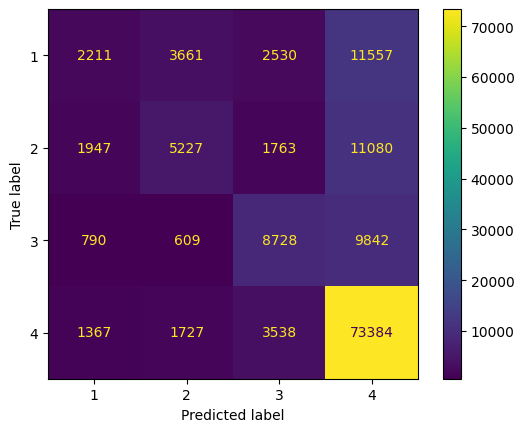

0.6398210930187695

In [33]:
from sklearn.linear_model import SGDClassifier
sgd_model = SGDClassifier(n_jobs=jobs, random_state=42)#, verbose=1)
train_and_test_model(sgd_model, X_train, X_test, y_train, y_test)

Nonparallelized SVC that scales quadratically with samples

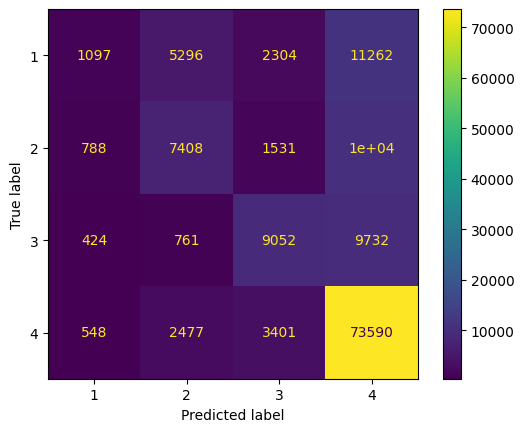

0.6512314144654582

In [34]:
from sklearn.svm import LinearSVC
svc_model = LinearSVC(random_state=42)#, verbose=1)
train_and_test_model(svc_model, X_train, X_test, y_train, y_test)


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

# Perform hyperparameter tuning with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],
}

svm_model = SVC(random_state=42)
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)


from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

# Perform hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['linear', 'rbf'],
}

svm_model = SVC(random_state=42)
random_search = RandomizedSearchCV(svm_model, param_distributions=param_dist, n_iter=5, cv=5)
random_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)

## Random Forest

Min-entropy was previously calculated, no need to recompute it

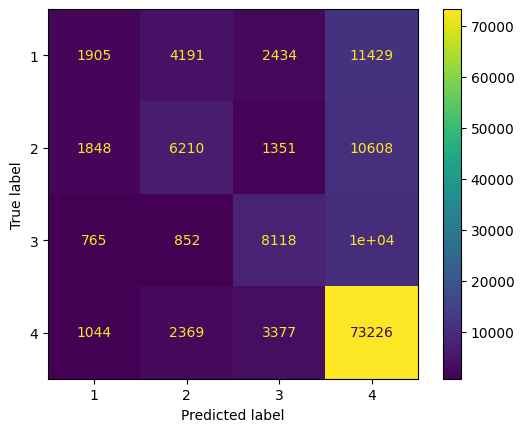

0.6391709118968856

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42, n_jobs=jobs)#, verbose=1)
train_and_test_model(rf_model, X_train, X_test, y_train, y_test)

from sklearn.ensemble import RandomForestClassifier

def calculate_min_entropy(sequence):
    sequence = np.asarray(sequence, dtype=float)  # Convert sequence to float
    p = np.mean(sequence)  # Proportion of ones
    max_prob = max(p, 1 - p)
    if max_prob == 0:  # Handle the case where all bits are the same
        return 0
    min_entropy = -np.log2(max_prob)
    return min_entropy




vectorized_entropy = np.vectorize(calculate_min_entropy, signature='(n)->()')

# Calculate min-entropy for each sequence in the training and testing datasets
min_entropy_train = vectorized_entropy(X_train)
min_entropy_test = vectorized_entropy(X_test)

X_train_with_entropy = np.column_stack((X_train, min_entropy_train))
X_test_with_entropy = np.column_stack((X_test, min_entropy_test))
# Create the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train_with_entropy, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_with_entropy)

# Calculate the accuracy of the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],          # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],         # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],         # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],           # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt'],       # Number of features to consider when looking for the best split
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(rf_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_rf = best_model.predict(X_test)

# Calculate the accuracy of the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)
print("Best Hyperparameters:", best_params)


## Gradient Boosting

%%time
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(random_state=42)#, verbose=1)
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

A parallelized version is available as Histogram Gradient Boosting model

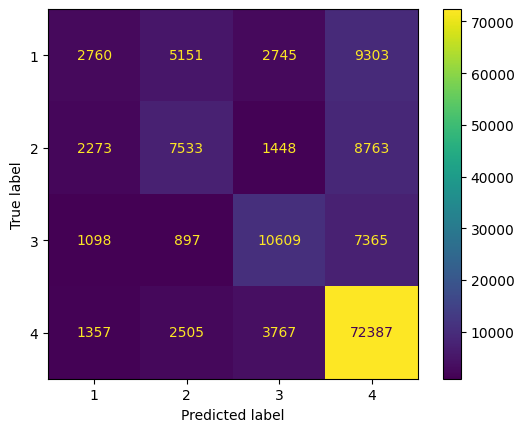

CPU times: user 5min 13s, sys: 3.86 s, total: 5min 17s
Wall time: 2min 50s


0.6665356777959575

In [36]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier
hgb_model = HistGradientBoostingClassifier(random_state=42)#, verbose=1)
train_and_test_model(hgb_model, X_train, X_test, y_train, y_test)

from sklearn.ensemble import GradientBoostingClassifier



# Create the Gradient Boosting classifier
gb_model = GradientBoostingClassifier(random_state=42)

# Train the model
# Train the model with the new feature included
gb_model.fit(X_train, y_train)

# Make predictions on the test set with the new feature included
y_pred_gb = gb_model.predict(X_test)

# Calculate the accuracy of the Gradient Boosting model with the new feature
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Accuracy with Min-Entropy Feature:", accuracy_gb)



GridSearch

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier


def calculate_min_entropy(sequence):
    sequence = np.asarray(sequence, dtype=float)  # Convert sequence to float
    p = np.mean(sequence)  # Proportion of ones
    max_prob = max(p, 1 - p)
    if max_prob == 0:  # Handle the case where all bits are the same
        return 0
    min_entropy = -np.log2(max_prob)
    return min_entropy




vectorized_entropy = np.vectorize(calculate_min_entropy, signature='(n)->()')

# Calculate min-entropy for each sequence in the training and testing datasets
min_entropy_train = vectorized_entropy(X_train)
min_entropy_test = vectorized_entropy(X_test)

X_train_with_entropy = np.column_stack((X_train, min_entropy_train))
X_test_with_entropy = np.column_stack((X_test, min_entropy_test))


# Create the Gradient Boosting classifier
gb_model = GradientBoostingClassifier(random_state=42)

# Define the hyperparameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Perform Grid Search with cross-validation (cv=5) to find the best hyperparameters
grid_search = GridSearchCV(gb_model, param_grid, cv=5)
grid_search.fit(X_train_with_entropy, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_gb = best_model.predict(X_test_with_entropy)

# Calculate the accuracy of the Gradient Boosting model with the best hyperparameters
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Best Hyperparameters:", best_params)
print("Gradient Boosting Accuracy:", accuracy_gb)


Other gradient boosted tree methods may have different runtime/performance

## XGBoost

%%time
from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state=42, verbosity=1, n_jobs=jobs, tree_method='exact')
y_train_mapped = y_train-1
y_test_mapped = y_test-1
train_and_test_model(xgb_model, X_train, X_test, y_train_mapped, y_test_mapped)

%%time
from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state=42, verbosity=1, n_jobs=jobs, tree_method='approx')
y_train_mapped = y_train-1
y_test_mapped = y_test-1
train_and_test_model(xgb_model, X_train, X_test, y_train_mapped, y_test_mapped)

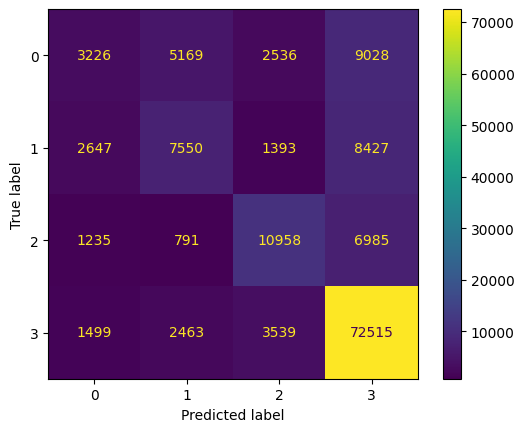

CPU times: user 2min 21s, sys: 2.05 s, total: 2min 23s
Wall time: 2min 24s


0.6733947313894585

In [37]:
%%time
from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state=42, verbosity=1, n_jobs=jobs, tree_method='hist')
y_train_mapped = y_train-1
y_test_mapped = y_test-1
train_and_test_model(xgb_model, X_train, X_test, y_train_mapped, y_test_mapped)

import xgboost as xgb
from sklearn.model_selection import GridSearchCV


# Create the XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42)

# Define the hyperparameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Map classes to [0, 1, 2]
y_train_mapped = y_train - 1  # This will change classes [1, 2, 3] to [0, 1, 2]

# Continue with the Grid Search
grid_search = GridSearchCV(xgb_model, param_grid, cv=5)
grid_search.fit(X_train, y_train_mapped)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

# Make predictions on the test set using the best XGBoost model
y_pred_xgb = best_xgb_model.predict(X_test)

# Calculate the accuracy of the XGBoost model with the best hyperparameters
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Best Hyperparameters for XGBoost:", best_params)
print("XGBoost Accuracy:", accuracy_xgb)


## CatBoost

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.337034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1950
[LightGBM] [Info] Number of data points in the train set: 559843, number of used features: 113
[LightGBM] [Info] Start training from score -1.945730
[LightGBM] [Info] Start training from score -1.946455
[LightGBM] [Info] Start training from score -1.945855
[LightGBM] [Info] Start training from score -0.559539


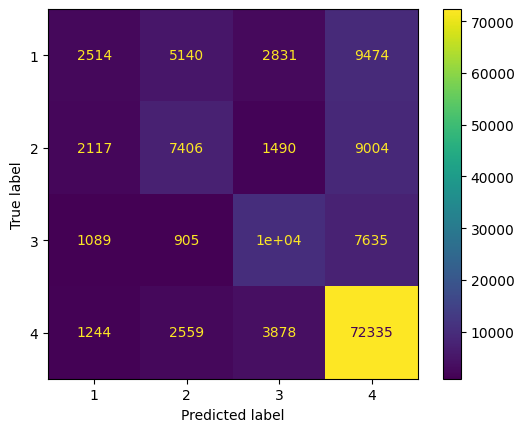

CPU times: user 3min 43s, sys: 2.38 s, total: 3min 45s
Wall time: 3min 50s


0.6615771536356556

In [38]:
%%time
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(random_state=42, n_jobs=jobs, boosting_type='gbdt')
train_and_test_model(lgb_model, X_train, X_test, y_train, y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.349261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1950
[LightGBM] [Info] Number of data points in the train set: 559843, number of used features: 113
[LightGBM] [Info] Start training from score -1.945730
[LightGBM] [Info] Start training from score -1.946455
[LightGBM] [Info] Start training from score -1.945855
[LightGBM] [Info] Start training from score -0.559539


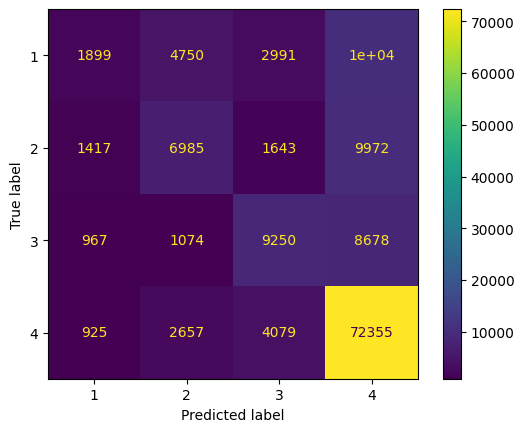

CPU times: user 4min 40s, sys: 1.97 s, total: 4min 42s
Wall time: 4min 43s


0.6465301048149127

In [39]:
%%time
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(random_state=42, n_jobs=jobs, boosting_type='dart')
train_and_test_model(lgb_model, X_train, X_test, y_train, y_test)

# fails
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(random_state=42, n_jobs=jobs, boosting_type='rf')
lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

import lightgbm as lgb

# Create the LightGBM classifier
lgb_model = lgb.LGBMClassifier(random_state=42)

# Define the hyperparameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Perform Grid Search with cross-validation (cv=5) to find the best hyperparameters
grid_search = GridSearchCV(lgb_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_lgb_model = grid_search.best_estimator_

# Make predictions on the test set using the best LightGBM model
y_pred_lgb = best_lgb_model.predict(X_test)

# Calculate the accuracy of the LightGBM model with the best hyperparameters
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print("Best Hyperparameters for LightGBM:", best_params)
print("LightGBM Accuracy:", accuracy_lgb)


## Neural Network

2024-06-04 20:02:54.715868: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 20:03:03.925609: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-04 20:03:17.485237: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-06-04 20:03:18.725126: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 202439048 exceeds 10% of free system memory.


 100/4374 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step 

2024-06-04 20:07:49.025866: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 63262372 exceeds 10% of free system memory.


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 4s 903us/step
Neural Network Accuracy: 0.6716370989061239


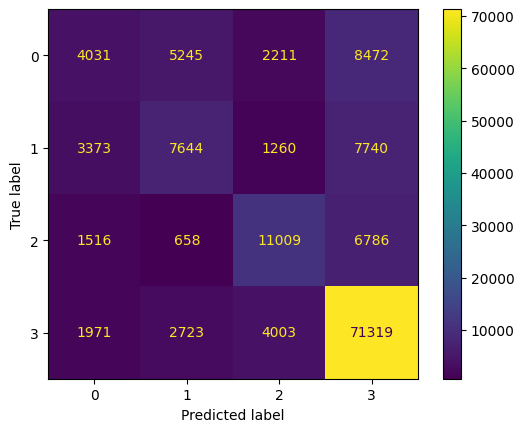

CPU times: user 6min 33s, sys: 42.1 s, total: 7min 15s
Wall time: 5min 20s


In [40]:
%%time
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

keras.utils.set_random_seed(42)

y_train_integer = y_train-1 #.astype('float32')
y_test_integer = y_test-1 #.astype('float32')

X_train_small, X_val, y_train_integer, y_val_integer = train_test_split(X_train, y_train_integer, test_size=0.2, random_state=42)
X_train_small = X_train_small.astype('float32')
X_val = X_val.astype('float32')

# Create the Neural Network model
nn_model = Sequential()
nn_model.add(Input(shape=(X_train_small.shape[1],)))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(4, activation='softmax'))

# Compile the model
nn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
nn_model.fit(X_train_small, y_train_integer, epochs=25, batch_size=64, validation_data=(X_val, y_val_integer), verbose=0)

# Make predictions on the test set
y_pred_probabilities = nn_model.predict(X_test.astype('float32'))
y_pred_nn = np.argmax(y_pred_probabilities, axis=-1)

# Calculate the accuracy of the Neural Network model
accuracy_nn = accuracy_score(y_test_integer, y_pred_nn)
print("Neural Network Accuracy:", accuracy_nn)
ConfusionMatrixDisplay.from_predictions(y_test_integer, y_pred_nn)
plt.show()
plt.close()

import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Assuming you have already defined X_train, X_test, y_train, and y_test

# Convert binary numbers to integer labels
label_encoder = LabelEncoder()
y_train_integer = label_encoder.transform(y_train)
y_test_integer = label_encoder.transform(y_test)

# Check unique values in y_train_integer and y_test_integer
print("Unique values in y_train:", np.unique(y_train_integer))
print("Unique values in y_test:", np.unique(y_test_integer))

print("Shape of y_train_integer:", y_train_integer.shape)
print("Shape of y_test_integer:", y_test_integer.shape)

# Manually split the data into training and validation sets
X_train, X_val, y_train_integer, y_val_integer = train_test_split(X_train, y_train_integer, test_size=0.2, random_state=42)

# Create the Neural Network model
nn_model = Sequential()
nn_model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(3, activation='softmax'))

# Compile the model
nn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
nn_model.fit(X_train, y_train_integer, epochs=2, batch_size=64, validation_data=(X_val, y_val_integer), verbose=0)

# Make predictions on the test set
y_pred_probabilities = nn_model.predict(X_test)
y_pred_nn = np.argmax(y_pred_probabilities, axis=-1)

# Calculate the accuracy of the Neural Network model
accuracy_nn = accuracy_score(y_test_integer, y_pred_nn)
print("Neural Network Accuracy:", accuracy_nn)


## LSTM

2024-06-04 20:07:58.436634: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 253049036 exceeds 10% of free system memory.
2024-06-04 20:15:33.155155: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 63262372 exceeds 10% of free system memory.


4374/4374 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
LSTM Accuracy: 0.6652924743321353


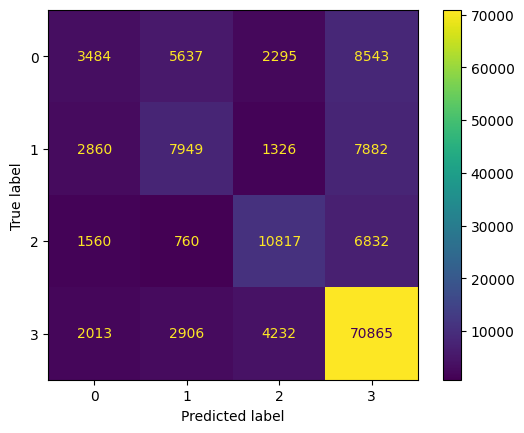

CPU times: user 14min 53s, sys: 1min 12s, total: 16min 6s
Wall time: 7min 45s


In [41]:
%%time
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

keras.utils.set_random_seed(42)

y_train_integer = y_train-1 #.astype('float32')
y_test_integer = y_test-1 #.astype('float32')

# Reshape the input data for LSTM
# TODO: LSTM with a single time step is not a sequence!
time_steps = 1  # Each sample is treated as a single time step
X_train_lstm = X_train.values.astype('float32').reshape(X_train.shape[0], time_steps, X_train.shape[1])
X_test_lstm = X_test.values.astype('float32').reshape(X_test.shape[0], time_steps, X_test.shape[1])
# y_train_lstm = y_train_integer.reshape(y_train_integer.shape[0], time_steps, y_train_integer.shape[1])

# Create the Neural Network model
lstm_model = Sequential()
lstm_model.add(Input(shape=(time_steps, X_train_lstm.shape[2])))
lstm_model.add(LSTM(32))
lstm_model.add(Dense(16, activation='relu'))
lstm_model.add(Dense(4, activation='softmax'))

# Compile the model
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
lstm_model.fit(X_train_lstm, y_train_integer, epochs=25, batch_size=64, verbose=0)

# Make predictions on the test set
y_pred_probabilities = lstm_model.predict(X_test_lstm)
y_pred_lstm = np.argmax(y_pred_probabilities, axis=-1)

# Calculate the accuracy of the LSTM model
accuracy_lstm = accuracy_score(y_test_integer, y_pred_lstm)
print("LSTM Accuracy:", accuracy_lstm)
ConfusionMatrixDisplay.from_predictions(y_test_integer, y_pred_lstm)
plt.show()
plt.close()

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ... (Previous code for reading and preprocessing the data)

# Convert the data into numerical format
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Reshape the input data for LSTM
time_steps = 1  # Each sample is treated as a single time step
X_train_lstm = X_train.reshape(X_train.shape[0], time_steps, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[1])

# Create the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(32, input_shape=(time_steps, X_train.shape[1])))
lstm_model.add(Dense(16, activation='relu'))
lstm_model.add(Dense(3, activation='sigmoid'))  # Assuming binary classification

# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=1)

# Make predictions on the test set
y_pred_lstm = lstm_model.predict(X_test_lstm)
y_pred_lstm = np.round(y_pred_lstm).astype(int).flatten()  # Convert probabilities to binary predictions

# Calculate the accuracy of the LSTM model
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
print("LSTM Accuracy:", accuracy_lstm)
